In [18]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping

from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, GRU, SimpleRNN
import glob
from datetime import datetime
from keras.layers import Dropout
#import pyemd
%matplotlib inline


In [2]:
import glob

all_data = pd.DataFrame()
path = 'C:\\Users\\kuruparans\\Documents\\Prof.Suganthan\\Canada_ON&QC_winddata_2017\\ON_Jan_*.xlsx'
for f in glob.glob(path):
    df = pd.read_excel(f, sheet_name=None, ignore_index=True, usecols=['windspd','month','day','hour'])
    cdf = pd.concat(df.values())
    all_data = all_data.append(cdf,ignore_index=True)
print(all_data)
dataframe=all_data

      day  hour  month  windspd
0     NaN   NaN    NaN      NaN
1     NaN   NaN    NaN      NaN
2     NaN   NaN    NaN      NaN
3     1.0   0.0    1.0     16.0
4     1.0   1.0    1.0     14.0
..    ...   ...    ...      ...
742  31.0  19.0    1.0     12.0
743  31.0  20.0    1.0      9.0
744  31.0  21.0    1.0     13.0
745  31.0  22.0    1.0     11.0
746  31.0  23.0    1.0     11.0

[747 rows x 4 columns]


In [3]:
month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [4]:
dataframe

,day,hour,month,windspd
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,1.0,0.0,1.0,16.0
4,1.0,1.0,1.0,14.0
5,1.0,2.0,1.0,14.0
6,1.0,3.0,1.0,28.0
7,1.0,4.0,1.0,25.0
8,1.0,5.0,1.0,24.0
9,1.0,6.0,1.0,27.0


In [5]:
dataframe['date_time']=(dataframe['month']-1)*30*24+(dataframe['day']-1) *24 + dataframe['hour']
dataframe=dataframe[['date_time','windspd'] ]
dataframe=dataframe.dropna()

In [6]:
dataframe

,date_time,windspd
3,0.0,16.0
4,1.0,14.0
5,2.0,14.0
6,3.0,28.0
7,4.0,25.0
8,5.0,24.0
9,6.0,27.0
10,7.0,22.0
11,8.0,21.0
12,9.0,15.0


In [7]:
''' Dividing data in test and train sets '''
dataset = dataframe.values
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

558 186


In [8]:
dataset

array([[  0.,  16.],
       [  1.,  14.],
       [  2.,  14.],
       ...,
       [741.,  13.],
       [742.,  11.],
       [743.,  11.]])

In [9]:
''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
''' Creating time frames with look backs '''
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

534
162


In [11]:
trainY

array([ 2.,  1.,  2.,  0.,  1.,  3.,  6.,  5.,  3.,  2.,  5.,  5.,  5.,
        6., 10.,  9., 11.,  8., 11.,  8.,  8.,  7.,  9.,  7., 10.,  7.,
       10., 10.,  9., 11.,  8., 10., 13.,  9., 10.,  9., 12., 12.,  8.,
        8.,  7.,  6.,  6.,  8., 12., 12.,  9., 11.,  8.,  4.,  7.,  5.,
        2.,  2.,  3.,  6., 22., 28., 24., 30., 30., 24., 37., 29., 38.,
       36., 36., 23., 37., 32., 34., 32., 34., 32., 34., 38., 33., 37.,
       30., 23., 22., 26., 19., 23., 25., 24., 28., 17., 18., 17., 11.,
       14., 10., 15., 13., 11.,  7., 10., 10.,  3.,  5.,  5.,  7.,  8.,
        2.,  6.,  5.,  5., 11., 11., 14., 12., 10.,  7.,  6.,  7.,  5.,
        6.,  4.,  0.,  4.,  4.,  3.,  6.,  4.,  4.,  7.,  6.,  2.,  6.,
        7.,  9.,  9.,  8.,  9.,  9.,  8.,  6.,  8.,  7.,  7.,  7.,  9.,
        3.,  6.,  8.,  3.,  4.,  7.,  7., 10.,  7.,  8., 11., 12., 13.,
       16., 21., 20., 19., 19., 10., 10.,  7.,  5.,  4.,  5.,  1.,  1.,
        0.,  0.,  2.,  2.,  3.,  4.,  4., 10.,  8., 12., 13., 21

In [12]:
trainX

array([[16., 14., 14., ...,  9.,  5.,  4.],
       [14., 14., 28., ...,  5.,  4.,  2.],
       [14., 28., 25., ...,  4.,  2.,  1.],
       ...,
       [21., 18., 19., ..., 18., 18., 19.],
       [18., 19., 18., ..., 18., 19., 20.],
       [19., 18., 15., ..., 19., 20., 22.]])

In [13]:
''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
trainX.shape



(534, 1, 24)

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 9s 17ms/step - loss: 11.4907 - val_loss: 12.4350
Epoch 2/300
534/534 [==============================] - 0s 98us/step - loss: 10.7090 - val_loss: 11.6940
Epoch 3/300
534/534 [==============================] - 0s 79us/step - loss: 9.9655 - val_loss: 10.8226
Epoch 4/300
534/534 [==============================] - 0s 61us/step - loss: 9.2531 - val_loss: 10.2156
Epoch 5/300
534/534 [==============================] - 0s 72us/step - loss: 8.7901 - val_loss: 9.8830
Epoch 6/300
534/534 [==============================] - 0s 77us/step - loss: 8.4862 - val_loss: 9.6255
Epoch 7/300
534/534 [==============================] - 0s 89us/step - loss: 8.2322 - val_loss: 9.3477
Epoch 8/300
534/534 [==============================] - 0s 75us/step - loss: 8.0087 - val_loss: 9.1192
Epoch 9/300
534/534 [==============================] - 0s 64us/step - loss: 7.8453 - val_loss: 8.9683
Epoch 10/300
534/534 [========

534/534 [==============================] - 0s 73us/step - loss: 4.5612 - val_loss: 4.6099
Epoch 81/300
534/534 [==============================] - 0s 64us/step - loss: 4.5717 - val_loss: 4.4499
Epoch 82/300
534/534 [==============================] - 0s 61us/step - loss: 4.5237 - val_loss: 4.5410
Epoch 83/300
534/534 [==============================] - 0s 58us/step - loss: 4.5203 - val_loss: 4.4572
Epoch 84/300
534/534 [==============================] - 0s 56us/step - loss: 4.4900 - val_loss: 4.4323
Epoch 85/300
534/534 [==============================] - 0s 95us/step - loss: 4.4588 - val_loss: 4.4774
Epoch 86/300
534/534 [==============================] - 0s 115us/step - loss: 4.4750 - val_loss: 4.3402
Epoch 87/300
534/534 [==============================] - 0s 147us/step - loss: 4.4291 - val_loss: 4.4297
Epoch 88/300
534/534 [==============================] - 0s 69us/step - loss: 4.4195 - val_loss: 4.3551
Epoch 89/300
534/534 [==============================] - 0s 58us/step - loss: 4.3970 

534/534 [==============================] - 0s 92us/step - loss: 2.5873 - val_loss: 2.9359
Epoch 237/300
534/534 [==============================] - 0s 59us/step - loss: 2.5640 - val_loss: 2.9618
Epoch 238/300
534/534 [==============================] - 0s 82us/step - loss: 2.5341 - val_loss: 2.9858
Epoch 239/300
534/534 [==============================] - 0s 113us/step - loss: 2.5148 - val_loss: 3.0651
Epoch 240/300
534/534 [==============================] - 0s 103us/step - loss: 2.5219 - val_loss: 3.0259
Epoch 241/300
534/534 [==============================] - 0s 114us/step - loss: 2.5384 - val_loss: 3.0066
Epoch 242/300
534/534 [==============================] - ETA: 0s - loss: 1.840 - 0s 101us/step - loss: 2.5251 - val_loss: 2.9260
Epoch 243/300
534/534 [==============================] - 0s 98us/step - loss: 2.5344 - val_loss: 2.9868
Epoch 244/300
534/534 [==============================] - 0s 116us/step - loss: 2.4950 - val_loss: 2.9587
Epoch 245/300
534/534 [==========================

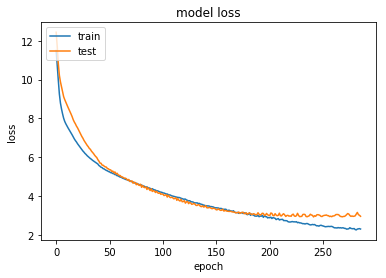

In [305]:
model = Sequential()
model.add(LSTM(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Root mean squared error Train: 4.088
Root mean squared error Test: 3.996


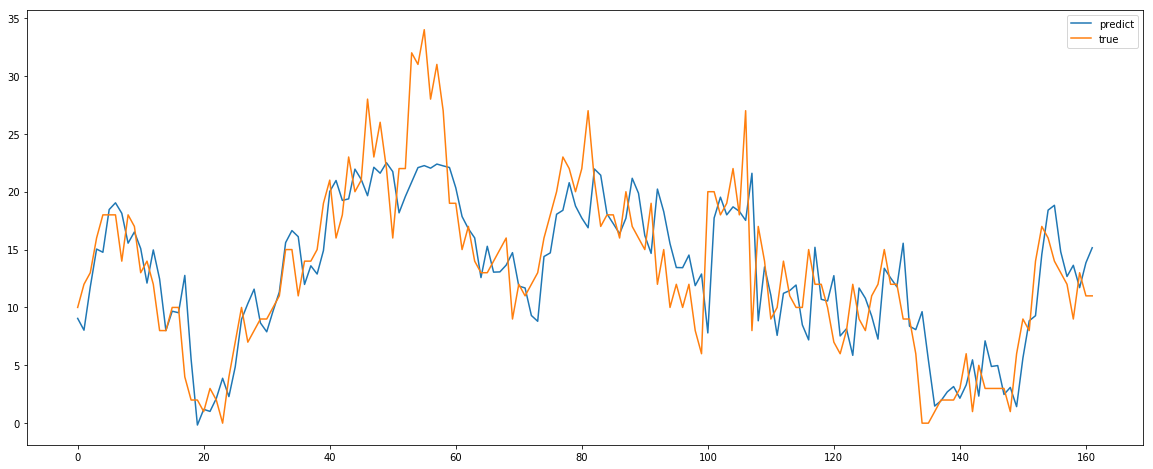

Variance : 0.678
Mean absolute error Train: 2.266
Mean absolute error Test: 2.959


In [306]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [307]:
#changing loss funtion to RMSE 

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 9s 18ms/step - loss: 12.8040 - acc: 0.0243 - val_loss: 13.2362 - val_acc: 0.0185
Epoch 2/300
534/534 [==============================] - 0s 85us/step - loss: 11.7159 - acc: 0.0431 - val_loss: 12.2376 - val_acc: 0.0123
Epoch 3/300
534/534 [==============================] - 0s 98us/step - loss: 10.9589 - acc: 0.0487 - val_loss: 11.4460 - val_acc: 0.0432
Epoch 4/300
534/534 [==============================] - 0s 92us/step - loss: 10.3636 - acc: 0.0581 - val_loss: 10.9550 - val_acc: 0.0247
Epoch 5/300
534/534 [==============================] - 0s 86us/step - loss: 9.9653 - acc: 0.0712 - val_loss: 10.6184 - val_acc: 0.0062
Epoch 6/300
534/534 [==============================] - 0s 83us/step - loss: 9.6995 - acc: 0.0543 - val_loss: 10.3963 - val_acc: 0.0000e+00
Epoch 7/300
534/534 [==============================] - 0s 86us/step - loss: 9.5120 - acc: 0.0543 - val_loss: 10.2201 - val_acc: 0.0000e+

Epoch 61/300
534/534 [==============================] - 0s 79us/step - loss: 6.1869 - acc: 0.1030 - val_loss: 5.9254 - val_acc: 0.0864
Epoch 62/300
534/534 [==============================] - 0s 67us/step - loss: 6.1657 - acc: 0.1030 - val_loss: 5.8877 - val_acc: 0.0926
Epoch 63/300
534/534 [==============================] - 0s 60us/step - loss: 6.1445 - acc: 0.1030 - val_loss: 5.8565 - val_acc: 0.0926
Epoch 64/300
534/534 [==============================] - 0s 70us/step - loss: 6.1228 - acc: 0.1011 - val_loss: 5.8230 - val_acc: 0.0864
Epoch 65/300
534/534 [==============================] - 0s 76us/step - loss: 6.1023 - acc: 0.1011 - val_loss: 5.7920 - val_acc: 0.0864
Epoch 66/300
534/534 [==============================] - 0s 63us/step - loss: 6.0812 - acc: 0.0993 - val_loss: 5.7586 - val_acc: 0.0864
Epoch 67/300
534/534 [==============================] - 0s 88us/step - loss: 6.0592 - acc: 0.0993 - val_loss: 5.7277 - val_acc: 0.0864
Epoch 68/300
534/534 [==============================] -

534/534 [==============================] - 0s 114us/step - loss: 4.4535 - acc: 0.1386 - val_loss: 4.0826 - val_acc: 0.1235
Epoch 182/300
534/534 [==============================] - 0s 112us/step - loss: 4.4428 - acc: 0.1404 - val_loss: 4.0789 - val_acc: 0.1173
Epoch 183/300
534/534 [==============================] - 0s 98us/step - loss: 4.4304 - acc: 0.1404 - val_loss: 4.0717 - val_acc: 0.1049
Epoch 184/300
534/534 [==============================] - 0s 82us/step - loss: 4.4196 - acc: 0.1442 - val_loss: 4.0680 - val_acc: 0.1111
Epoch 185/300
534/534 [==============================] - 0s 69us/step - loss: 4.4080 - acc: 0.1423 - val_loss: 4.0606 - val_acc: 0.1049
Epoch 186/300
534/534 [==============================] - 0s 54us/step - loss: 4.3975 - acc: 0.1367 - val_loss: 4.0574 - val_acc: 0.1111
Epoch 187/300
534/534 [==============================] - 0s 50us/step - loss: 4.3855 - acc: 0.1348 - val_loss: 4.0525 - val_acc: 0.1111
Epoch 188/300
534/534 [==============================] - 0s 

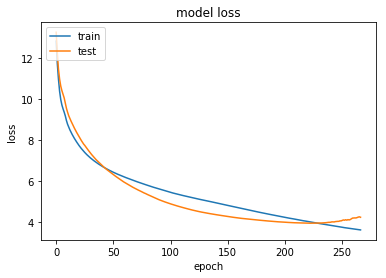

Root mean squared error Train: 4.546
Root mean squared error Test: 4.323


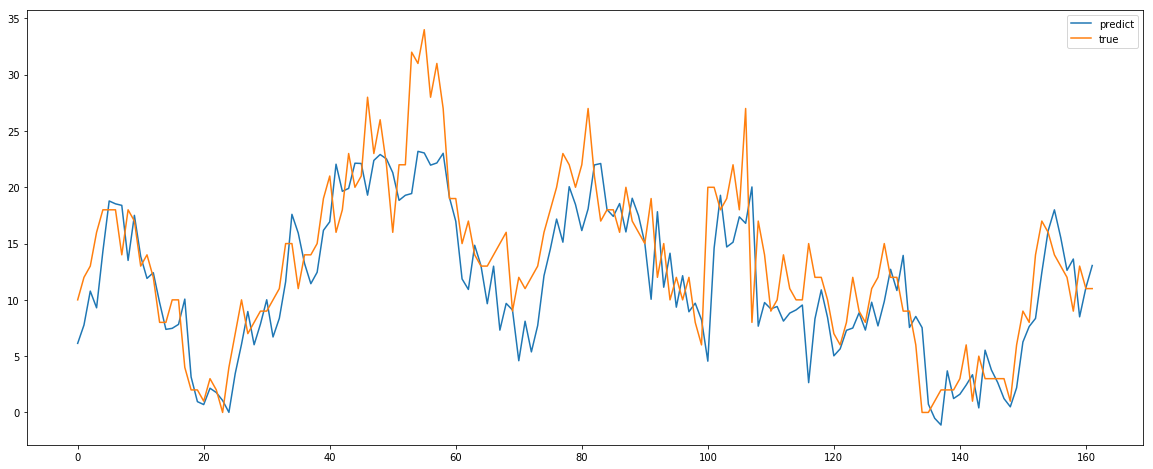

Variance : 0.623
Mean absolute error Train: 2.866
Mean absolute error Test: 3.247


In [308]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(LSTM(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [309]:
#GRU Unit

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 10s 18ms/step - loss: 11.3918 - val_loss: 11.9743
Epoch 2/300
534/534 [==============================] - 0s 106us/step - loss: 10.2833 - val_loss: 11.0531
Epoch 3/300
534/534 [==============================] - 0s 169us/step - loss: 9.5082 - val_loss: 10.4410
Epoch 4/300
534/534 [==============================] - 0s 141us/step - loss: 8.9606 - val_loss: 9.9603
Epoch 5/300
534/534 [==============================] - 0s 122us/step - loss: 8.5530 - val_loss: 9.5776
Epoch 6/300
534/534 [==============================] - 0s 102us/step - loss: 8.2266 - val_loss: 9.2233
Epoch 7/300
534/534 [==============================] - 0s 80us/step - loss: 7.9480 - val_loss: 8.9201
Epoch 8/300
534/534 [==============================] - 0s 88us/step - loss: 7.7108 - val_loss: 8.7026
Epoch 9/300
534/534 [==============================] - 0s 80us/step - loss: 7.5483 - val_loss: 8.5146
Epoch 10/300
534/534 [===

Epoch 80/300
534/534 [==============================] - 0s 59us/step - loss: 4.9654 - val_loss: 4.7074
Epoch 81/300
534/534 [==============================] - 0s 64us/step - loss: 4.9759 - val_loss: 4.5868
Epoch 82/300
534/534 [==============================] - 0s 65us/step - loss: 4.9445 - val_loss: 4.6698
Epoch 83/300
534/534 [==============================] - 0s 42us/step - loss: 4.9485 - val_loss: 4.5638
Epoch 84/300
534/534 [==============================] - 0s 53us/step - loss: 4.9151 - val_loss: 4.6285
Epoch 85/300
534/534 [==============================] - 0s 58us/step - loss: 4.9163 - val_loss: 4.5347
Epoch 86/300
534/534 [==============================] - 0s 66us/step - loss: 4.8866 - val_loss: 4.5998
Epoch 87/300
534/534 [==============================] - 0s 93us/step - loss: 4.8845 - val_loss: 4.4975
Epoch 88/300
534/534 [==============================] - 0s 96us/step - loss: 4.8600 - val_loss: 4.5556
Epoch 89/300
534/534 [==============================] - 0s 94us/step - lo

534/534 [==============================] - 0s 119us/step - loss: 2.9937 - val_loss: 2.9919
Epoch 237/300
534/534 [==============================] - 0s 99us/step - loss: 2.9718 - val_loss: 2.9750
Epoch 238/300
534/534 [==============================] - 0s 104us/step - loss: 2.9145 - val_loss: 3.0015
Epoch 239/300
534/534 [==============================] - 0s 100us/step - loss: 2.8999 - val_loss: 3.0691
Epoch 240/300
534/534 [==============================] - 0s 110us/step - loss: 2.9049 - val_loss: 3.0435
Epoch 241/300
534/534 [==============================] - 0s 94us/step - loss: 2.9043 - val_loss: 2.9981
Epoch 242/300
534/534 [==============================] - 0s 104us/step - loss: 2.9458 - val_loss: 2.9732
Epoch 243/300
534/534 [==============================] - 0s 101us/step - loss: 2.9386 - val_loss: 2.9708
Epoch 244/300
534/534 [==============================] - 0s 103us/step - loss: 2.8815 - val_loss: 2.9765
Epoch 245/300
534/534 [==============================] - 0s 84us/step -

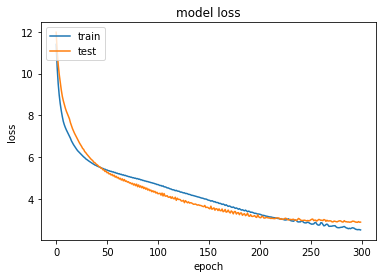

In [310]:
model = Sequential()
model.add(GRU(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Root mean squared error Train: 4.333
Root mean squared error Test: 3.845


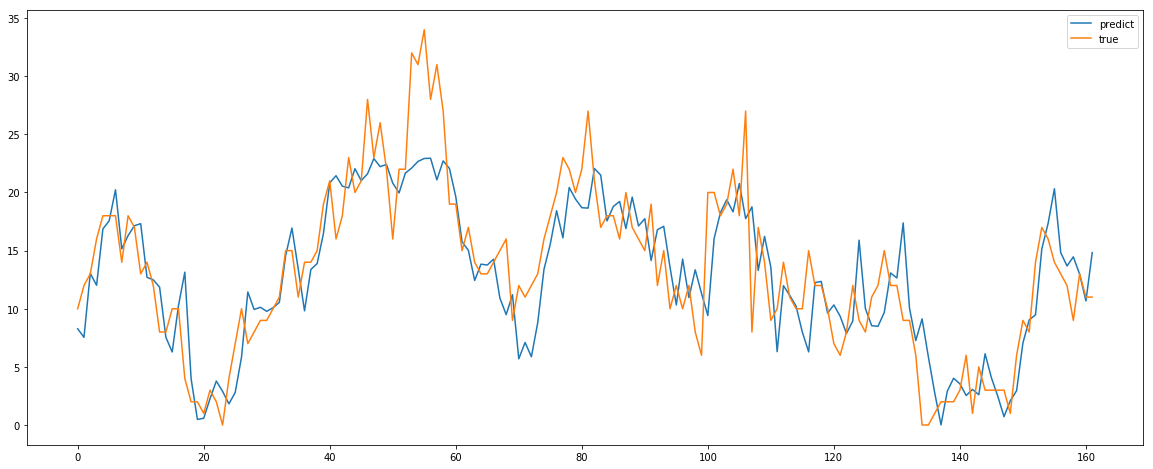

Variance : 0.702
Mean absolute error Train: 2.480
Mean absolute error Test: 2.893


In [311]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))


Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 10s 19ms/step - loss: 13.1568 - acc: 0.0262 - val_loss: 13.5799 - val_acc: 0.0123
Epoch 2/300
534/534 [==============================] - 0s 66us/step - loss: 12.1515 - acc: 0.0356 - val_loss: 12.6993 - val_acc: 0.0185
Epoch 3/300
534/534 [==============================] - 0s 77us/step - loss: 11.5107 - acc: 0.0468 - val_loss: 12.1944 - val_acc: 0.0556
Epoch 4/300
534/534 [==============================] - 0s 70us/step - loss: 11.0464 - acc: 0.0524 - val_loss: 11.6582 - val_acc: 0.0185
Epoch 5/300
534/534 [==============================] - 0s 75us/step - loss: 10.5702 - acc: 0.0637 - val_loss: 11.2390 - val_acc: 0.0185
Epoch 6/300
534/534 [==============================] - 0s 96us/step - loss: 10.2257 - acc: 0.0637 - val_loss: 10.8652 - val_acc: 0.0123
Epoch 7/300
534/534 [==============================] - 0s 88us/step - loss: 9.9207 - acc: 0.0674 - val_loss: 10.5794 - val_acc: 0.0062
Ep

534/534 [==============================] - 0s 86us/step - loss: 5.4258 - acc: 0.1161 - val_loss: 4.9102 - val_acc: 0.1049
Epoch 122/300
534/534 [==============================] - 0s 121us/step - loss: 5.4122 - acc: 0.1142 - val_loss: 4.8941 - val_acc: 0.1049
Epoch 123/300
534/534 [==============================] - 0s 98us/step - loss: 5.3981 - acc: 0.1161 - val_loss: 4.8789 - val_acc: 0.0988
Epoch 124/300
534/534 [==============================] - 0s 85us/step - loss: 5.3852 - acc: 0.1142 - val_loss: 4.8682 - val_acc: 0.0988
Epoch 125/300
534/534 [==============================] - 0s 82us/step - loss: 5.3695 - acc: 0.1161 - val_loss: 4.8527 - val_acc: 0.0988
Epoch 126/300
534/534 [==============================] - 0s 87us/step - loss: 5.3568 - acc: 0.1217 - val_loss: 4.8393 - val_acc: 0.1049
Epoch 127/300
534/534 [==============================] - 0s 81us/step - loss: 5.3436 - acc: 0.1199 - val_loss: 4.8227 - val_acc: 0.0988
Epoch 128/300
534/534 [==============================] - 0s 8

Epoch 241/300
534/534 [==============================] - 0s 87us/step - loss: 4.0804 - acc: 0.1742 - val_loss: 4.0737 - val_acc: 0.1358
Epoch 242/300
534/534 [==============================] - 0s 82us/step - loss: 4.0729 - acc: 0.1798 - val_loss: 4.0707 - val_acc: 0.1296
Epoch 243/300
534/534 [==============================] - 0s 115us/step - loss: 4.0638 - acc: 0.1779 - val_loss: 4.0679 - val_acc: 0.1420
Epoch 244/300
534/534 [==============================] - 0s 121us/step - loss: 4.0578 - acc: 0.1910 - val_loss: 4.0668 - val_acc: 0.1420
Epoch 245/300
534/534 [==============================] - 0s 155us/step - loss: 4.0501 - acc: 0.1854 - val_loss: 4.0683 - val_acc: 0.1420
Epoch 246/300
534/534 [==============================] - 0s 142us/step - loss: 4.0400 - acc: 0.1891 - val_loss: 4.0617 - val_acc: 0.1481
Epoch 247/300
534/534 [==============================] - 0s 170us/step - loss: 4.0348 - acc: 0.1891 - val_loss: 4.0604 - val_acc: 0.1481
Epoch 248/300
534/534 [====================

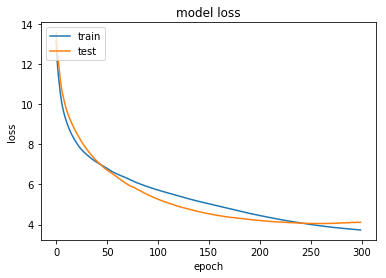

In [312]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(GRU(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Root mean squared error Train: 4.448
Root mean squared error Test: 4.187


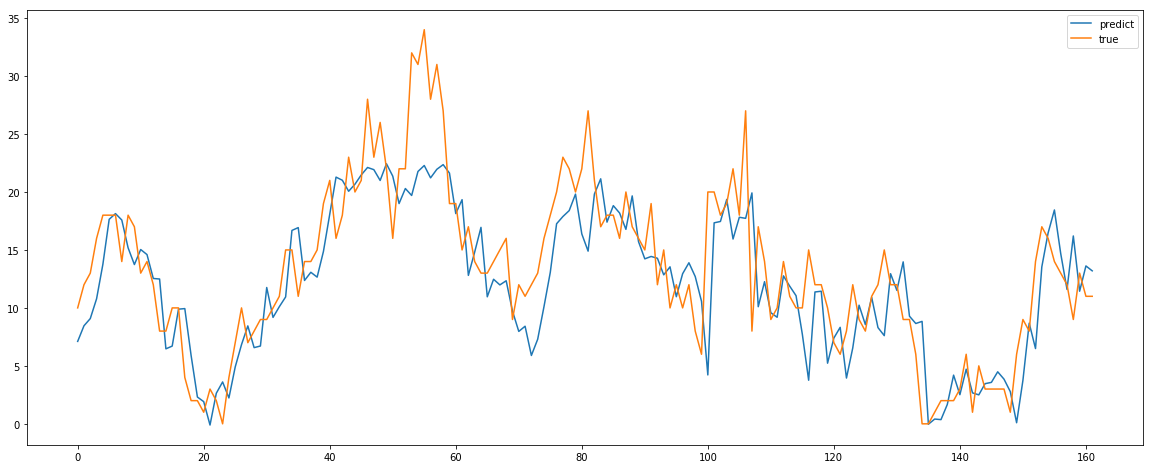

Variance : 0.647
Mean absolute error Train: 2.717
Mean absolute error Test: 3.098


In [313]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [ ]:
#Simple RNN Unit

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 25        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'loss'])


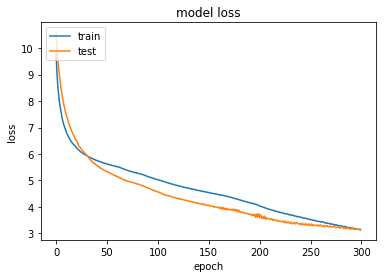

Root mean squared error Train: 5.026
Root mean squared error Test: 4.277


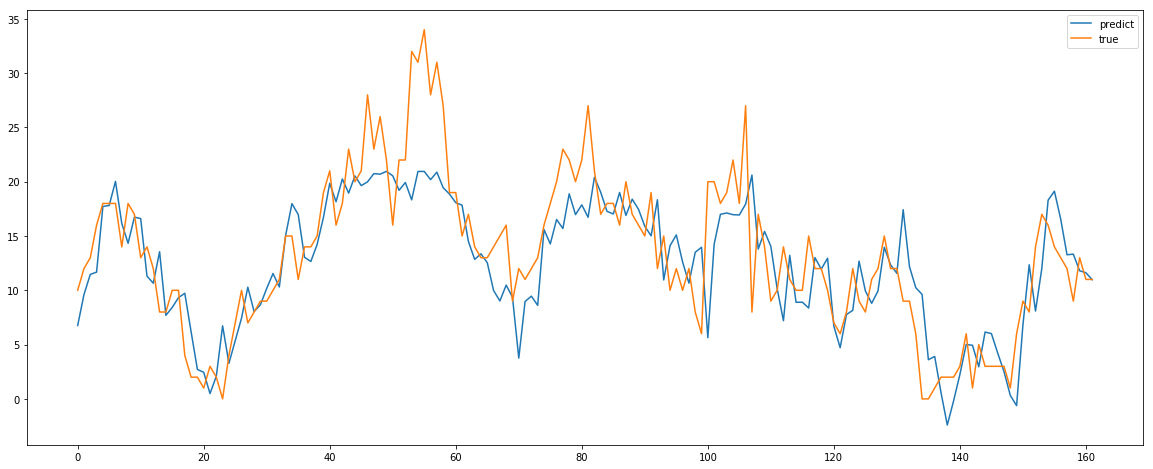

Variance : 0.631
Mean absolute error Train: 3.108
Mean absolute error Test: 3.161


In [314]:
model = Sequential()
model.add(SimpleRNN(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


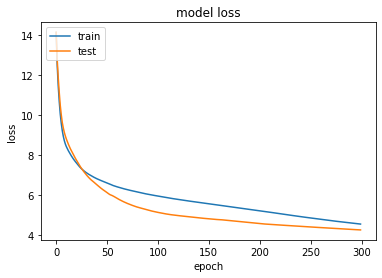

Root mean squared error Train: 5.141
Root mean squared error Test: 4.371


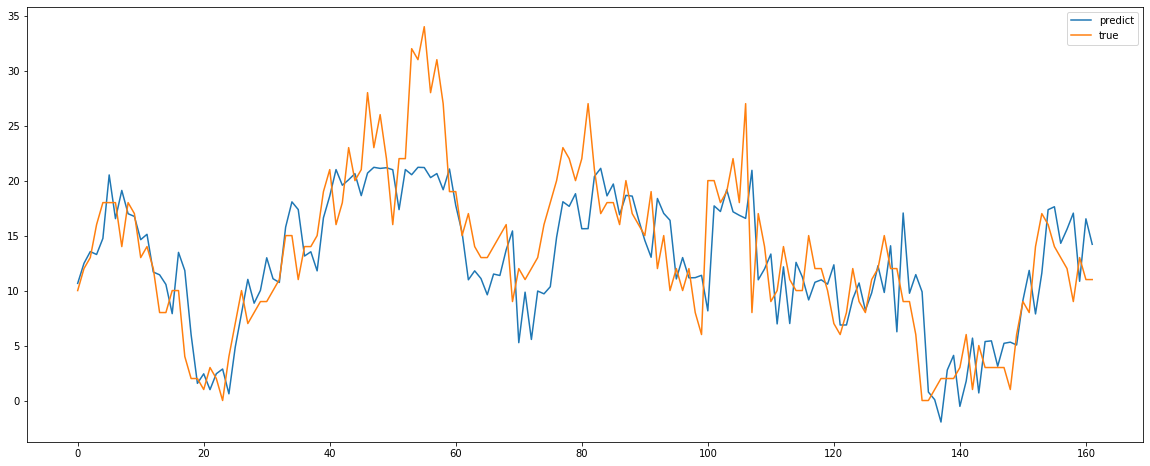

Variance : 0.615
Mean absolute error Train: 3.401
Mean absolute error Test: 3.340


In [17]:
 from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(SimpleRNN(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))